<a href="https://colab.research.google.com/github/mma-dev-92/mma-dev-92/blob/main/svm_vectorized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the envirnoment

In [ ]:
!python --version

Python 3.10.12


### Graphic card

# Preprocessing (preparation of input data)

In [35]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from google.colab import drive


In [36]:
def plot_input_data(
        X: np.ndarray,
        y: np.ndarray,
) -> None:
    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.show()

input_data = dict()

###  2D datasets (for presentation only)

#### Lineary separable dataset

In [45]:
def lin_separate(
        X: np.ndarray,
) -> tuple[np.ndarray, float]:
    n_features = X.shape[1]
    bias = np.random.random()
    w = np.random.random(n_features)

    y = w.dot(X.T) + bias
    return np.sign(y)

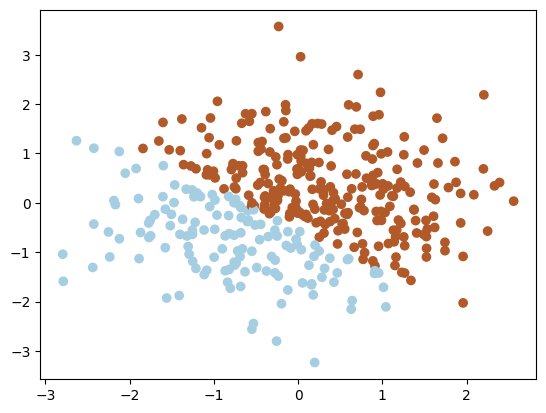

In [46]:
np.random.seed(123)

d, N = 2, 400
X = np.random.multivariate_normal(np.zeros(d), np.identity(d), size=N)
y = lin_separate(X)
plot_input_data(X, y)
input_data['lin_sep'] = X, y

#### Moon-like dataset

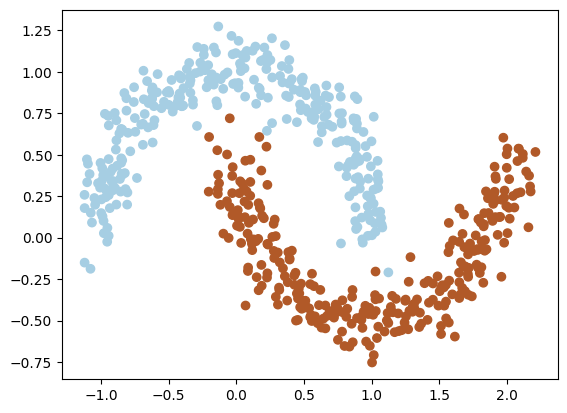

In [47]:
N = 600
X, y = datasets.make_moons(n_samples=N, noise=0.1, random_state=42)
y = (y - 0.5) * 2
plot_input_data(X, y)
input_data['moon'] = X, y

 #### Donut-like dataset

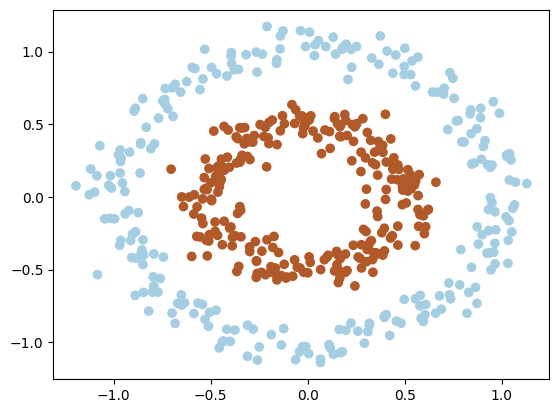

In [48]:
N = 500
X, y = datasets.make_circles(n_samples=N, factor=0.5, noise=0.08, random_state=2)
y = (y - 0.5) * 2
plot_input_data(X, y)
input_data['donut'] = X, y

### Large datasets (for benchmarking)

#### Random data (not linear separable)

In [49]:
d, N = 1000, 1000
np.random.seed(123)
X = np.random.multivariate_normal(np.zeros(d), np.identity(d), size=N)
y = np.random.choice([-1, 1], N)
print(X.shape, y.shape)
input_data['big_random'] = X, y

(1000, 1000) (1000,)


#### Spam vs nospam email dataset from kaggle

link to dataset: https://www.kaggle.com/datasets/imgowthamg/email-spam-and-non-spam-datasets?resource=download

NOTE:  in a real world I would use sparse matrices. Instead will use this dataset to measure the GPU speedup.

In [50]:
from google.colab import drive
drive.mount('/content/drive')
datapath = '/content/drive/MyDrive/datasets/mail_data.csv'
dataset = pd.read_csv(datapath, sep=',')
dataset.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [51]:
vectorizer = CountVectorizer(binary=True)
stats = vectorizer.fit_transform(dataset['Message'])

feature_names = vectorizer.get_feature_names_out()
df_features = pd.DataFrame(stats.toarray(), columns=feature_names)

result_df = pd.concat([dataset, df_features], axis=1)
result_df.drop(columns=['Message'], inplace=True)

result_df.head()

,Category,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
0,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
X, y = result_df.values[:, 1:], result_df.values[:, 0]
y[y == 'ham'] = 1
y[y == 'spam'] = -1
print(X.shape, y.shape)
input_data['spam'] = X, y

(5572, 8709) (5572,)


# SVM implementation from skratch (using only tensorflow)

#### import required lib

In [31]:
import tensorflow as tf

#### Helper functions

In [92]:
def decision_function(
        K: tf.Tensor,
        w: tf.Tensor,
        b: float
) -> tf.Tensor:
    return tf.add(tf.linalg.matvec(tf.transpose(K), w), b)


def xi(
        y: tf.Tensor,
        K: tf.Tensor,
        w: tf.Tensor,
        b: float
) -> tf.Tensor:
    return tf.multiply(y, decision_function(K, w, b))


def predict(
        K: tf.Tensor,
        w: tf.Tensor,
        b: float
) -> tf.Tensor:
    return tf.sign(decision_function(K, w, b))


def accuracy(
        y: tf.Tensor,
        K: tf.Tensor,
        w: tf.Tensor,
        b: float
) -> float:
    return float(tf.reduce_mean(tf.cast(y == predict(K, w, b), tf.float64)))


#### Kernel matrix computation

In [101]:
def _get_gamma(gamma: float, N: int) -> float:
    if gamma is not None:
        return gamma
    return 1.0 / N


def linear_kernel(
    X1: tf.Tensor,
    X2: tf.Tensor,
    gamma: float | None = None,
) -> tf.Tensor:
    gamma = _get_gamma(gamma, X1.shape[1])
    return tf.matmul(X1, tf.transpose(X2))


def polynomial_kernel(
    X1: tf.Tensor,
    X2: tf.Tensor,
    degree: int,
    transl: float,
    gamma: float | None = None,
) -> tf.Tensor:
    gamma = _get_gamma(gamma, X1.shape[1])
    return (tf.matmul(X1, tf.transpose(X2)) * gamma + transl) ** degree


def rbf_kernel(
    X1: tf.Tensor,
    X2: tf.Tensor,
    gamma: float | None,
) -> tf.Tensor:
    gamma = _get_gamma(gamma, X1.shape[1])
    norm = tf.math.reduce_euclidean_norm((X1[:, None] - X2[None, :]), axis=2)
    return tf.math.exp(-gamma * (norm ** 2))

kernels = {
    'linear': linear_kernel,
    'poly': polynomial_kernel,
    'rbf': rbf_kernel,
}

def compute_kernel(X1: tf.Tensor, X2: tf.Tensor, name: str, **kwargs) -> tf.Tensor:
    if name not in kernels:
        raise KeyError(
            f'kernel name {name} is incorrect, possible kernels are '
            f'{list(kernels.keys())}'
        )
    return kernels[name](X1, X2, **kwargs)

#### Gradient descent optimization

In [120]:
def fit(
        K: tf.Tensor,
        y: tf.Tensor,
        lr: float = 1e-3,
        epochs: int = 500,
        C: float = 1.0,
        tee: int | None = None,
) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor, float]:
    """
    SVM classifier training

    :param K: kernel matrix
    :param y: training set classification (given apriori)
    :param lr: learning rate for the gradient descent algorithm
    :param epochs: number of epochs
    :param C: regularization constant hyperparameter
    :return: score_per_epoch, obj_per_epoch, w, bias,
    """
    score_per_epoch, obj_per_epoch = [], []
    w, b = tf.constant(np.random.randn(y.shape[0])), np.random.random()
    for epoch in range(epochs):

        margin = xi(y, K, w, b)
        bad_guesses = margin < 1

        dw = tf.linalg.matvec(tf.transpose(K), w) - C * tf.linalg.matvec(tf.transpose(K[bad_guesses]), y[bad_guesses])
        w = w - lr * dw

        db = -C * tf.reduce_sum(y[bad_guesses])
        b = b - lr * db

        q = tf.reduce_sum(tf.multiply(tf.linalg.matvec(K, w), w))
        m = C * tf.reduce_sum(tf.maximum(0, 1 - margin))
        obj = float(q + m)

        score = accuracy(y, K, w, b)

        obj_per_epoch.append(obj)
        score_per_epoch.append(score)

        if tee is not None and epoch % tee == 0:
          print("epoch ", epoch, " | obj ", obj, " | accuracy ", score)

    return tf.constant(score_per_epoch), tf.constant(obj_per_epoch), w, b


# SVM implementation using scikit-learn package

# Postprocessing

In [187]:
def plot_stats(
        X: tf.Tensor,
        y: tf.Tensor,
        w: tf.Tensor,
        b: float,
        kernel_function,
        obj: tf.Tensor,
        err: tf.Tensor,
) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
    ax1.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

    x_axis_range = ax1.get_xlim()
    y_axis_range = ax1.get_ylim()

    x_grid, y_grid = np.meshgrid(
        np.linspace(x_axis_range[0], x_axis_range[1], 50),
        np.linspace(y_axis_range[0], y_axis_range[1])
    )

    grid = tf.constant(np.vstack([x_grid.ravel(), y_grid.ravel()]).T)
    z = decision_function(
        kernel_function(grid), w, b).numpy().reshape(x_grid.shape)

    ax1.contour(
        x_grid,
        y_grid,
        z,
        colors=['green', 'blue', 'purple'],
        levels=[-1, 0, 1],
        linestyles=['--', '-', '--'],
        linewidths=2.0
    )

    ax2.plot(np.arange(obj.shape[0]), obj)
    ax2.set(xlabel="epochs", ylabel="obj value")
    ax2.set_title("Objective value per epoch")


    ax3.plot(np.arange(err.shape[0]), 1 - err)
    ax3.set(xlabel="epochs", ylabel="error")
    ax3.set_title("Error per epoch")

    # plot_obj(axes[0], obj)
    # plot_error(axes[1], err)
    fig.show()


#  SVD tensorflow method presentation

In [196]:
def run_tf_impl(
        dataset: str,
        kernel: str,
        lr: float = 1e-3,
        epochs: int = 500,
        C = 1.0,
        tee: int | None = None,
        **kernel_params
) -> None:
    if dataset not in input_data:
        raise KeyError(
            f'dataset name {dataset} is incorrect, possible datasets are '
            f'{list(input_data.keys())}'
        )

    X, y = input_data.get(dataset)
    X, y = tf.constant(X), tf.constant(y)

    K = compute_kernel(X, X, kernel, **kernel_params)
    accuracy_per_epoch, obj_per_epoch, w, b = fit(K, y, lr, epochs, C, tee)
    print(f'Accuracy: {accuracy(y, K, w, b)}')
    plot_stats(
        X, y, w, b, lambda m: compute_kernel(X, m, kernel, **kernel_params),
        obj_per_epoch, accuracy_per_epoch)
    # plot_data_boundary(
    #     X, y, w, b, lambda m: compute_kernel(X, m, kernel, **kernel_params))


#### Lineary separable dataset

epoch  0  | obj  4295.0707956553215  | accuracy  0.5425
epoch  100  | obj  164.9769170310307  | accuracy  0.8525
epoch  200  | obj  74.5819084421277  | accuracy  0.9625
epoch  300  | obj  72.2039531760466  | accuracy  0.9625
epoch  400  | obj  70.11229181483966  | accuracy  0.9675
Accuracy: 0.97


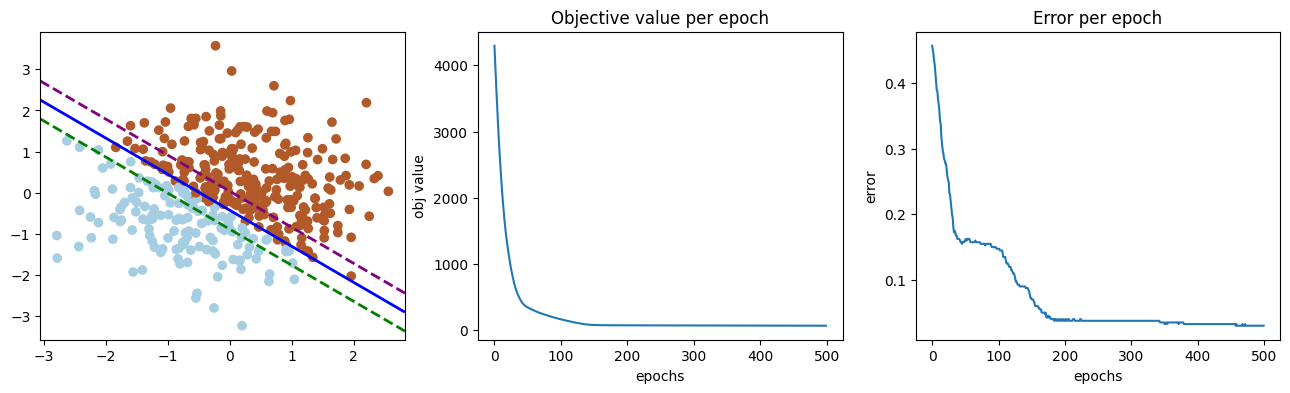

In [197]:
run_tf_impl(
    dataset='lin_sep',
    kernel='linear',
    lr=1e-5,
    epochs=500,
    C=1.0,
    tee=100,
)

#### Donut-like dataset

epoch  0  | obj  32321.064573114374  | accuracy  0.522
epoch  100  | obj  370.2938709046698  | accuracy  0.856
epoch  200  | obj  161.86198825231318  | accuracy  0.99
epoch  300  | obj  129.24109276827554  | accuracy  0.994
epoch  400  | obj  110.08444874326555  | accuracy  0.998
epoch  500  | obj  96.08899939432953  | accuracy  0.998
epoch  600  | obj  85.88915958361619  | accuracy  1.0
epoch  700  | obj  77.33214350028848  | accuracy  1.0
epoch  800  | obj  72.10250087262708  | accuracy  1.0
epoch  900  | obj  66.50549491585235  | accuracy  1.0
Accuracy: 1.0


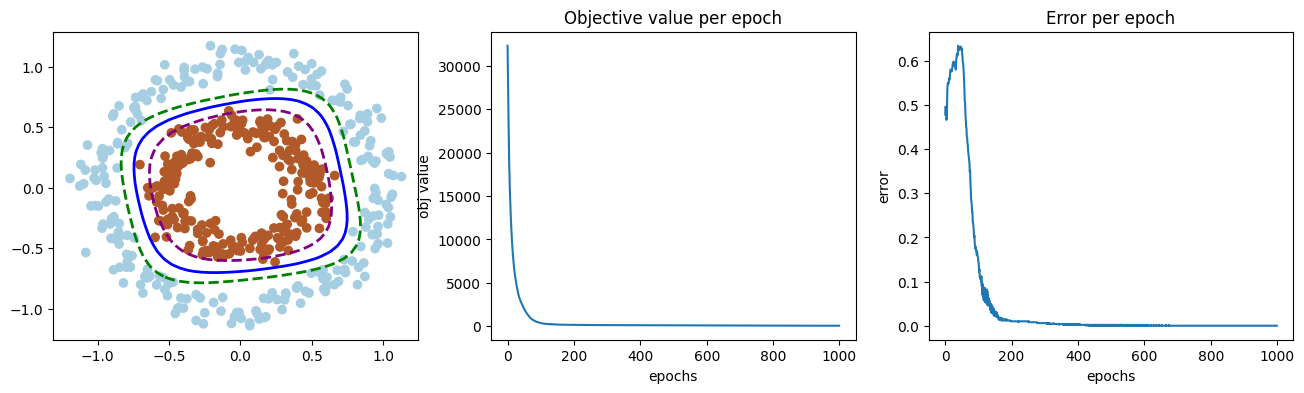

In [201]:
run_tf_impl(
    dataset='donut',
    kernel='poly',
    lr=1e-5,
    epochs=1000,
    C=1.0,
    tee=100,
    degree=4,
    transl=1.0,
    gamma=1.0,
)

epoch  0  | obj  1820.772577660601  | accuracy  0.6866666666666666
epoch  100  | obj  133.03622144820372  | accuracy  0.9916666666666667
epoch  200  | obj  99.40493002221905  | accuracy  0.9933333333333333
epoch  300  | obj  90.52672432396042  | accuracy  0.9966666666666667
epoch  400  | obj  84.98995824670733  | accuracy  0.9966666666666667
epoch  500  | obj  80.69632065058038  | accuracy  0.9966666666666667
epoch  600  | obj  77.8102505930326  | accuracy  0.9966666666666667
epoch  700  | obj  75.28463896651404  | accuracy  0.9966666666666667
epoch  800  | obj  73.1318697524761  | accuracy  0.9966666666666667
epoch  900  | obj  71.55814306944109  | accuracy  0.9966666666666667
Accuracy: 0.9966666666666667


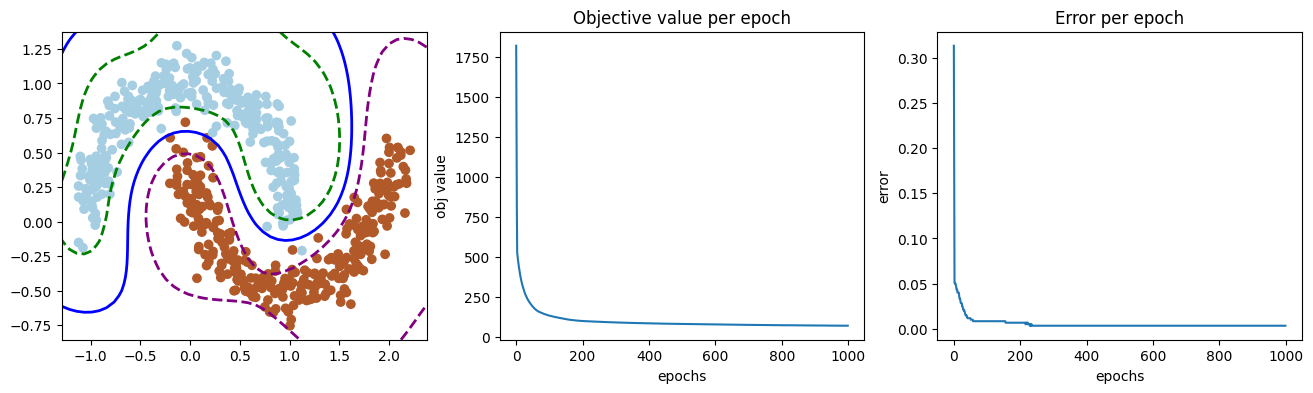

In [199]:
run_tf_impl(
    dataset='moon',
    kernel='rbf',
    lr=1e-4,
    epochs=1000,
    C=2.0,
    tee=100,
    gamma=2.04,
)